### Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import math

from sklearn.metrics import log_loss, make_scorer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold, StratifiedGroupKFold
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings("ignore")


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Data Prep

In [2]:
COMP_PATH = "/kaggle/input/icr-identify-age-related-conditions"
train = pd.read_csv(f"{COMP_PATH}/train.csv")
test = pd.read_csv(f"{COMP_PATH}/test.csv")
sample_submission = pd.read_csv(f"{COMP_PATH}/sample_submission.csv")
greeks = pd.read_csv(f"{COMP_PATH}/greeks.csv")

In [3]:
# Label encoding
train['EJ'] = train['EJ'].map({'A': 0, 'B': 1})
test['EJ']  = test['EJ'].map({'A': 0, 'B': 1})

In [4]:
train = train.fillna(train.median())

In [5]:
train.sample(10)

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
611,fd1dd68d51b4,0.175193,2607.26686,85.200147,7.067354,8.138688,4.030845,0.025578,3.396778,1.229900,...,0.173229,1.89486,1.395238,16.911036,246.093155,10960.364830,38.380254,41.007968,21.978000,0
38,10aaf6adb652,0.397389,2451.22889,104.986995,67.852173,8.138688,7.539009,0.025578,12.793060,1.229900,...,4.226611,0.80591,1.246232,27.329276,94.408958,56896.666140,31.234074,21.921156,0.198000,0
384,94f28a9c879b,0.277745,1981.52988,85.200147,9.997116,13.466592,4.987617,0.077343,3.396778,4.772012,...,0.173229,1.29050,0.067730,16.101762,121.418913,5451.622380,22.519492,35.874256,21.978000,0
468,b9e388b48268,0.559763,3477.18184,85.200147,99.001799,8.138688,4.907886,0.049938,12.269994,12.847184,...,22.867930,1.11012,0.785668,30.268708,72.611063,9197.371638,44.149665,55.856124,0.073697,0
196,4bc8f3ea493a,0.611039,1614.33602,92.419908,35.751768,8.138688,6.679686,0.025578,8.129580,28.287700,...,5.192682,2.51111,0.711165,27.636242,120.939668,5159.734425,18.218016,18.276632,0.172565,0
543,dd3515028d71,0.363205,6776.09196,85.200147,15.026644,8.138688,6.839148,0.025578,10.852044,1.229900,...,4.072643,1.87659,0.304785,12.994894,72.611063,6171.724935,25.581875,52.394212,0.171346,0
368,8ead0a51d11c,0.767003,7205.59114,85.200147,25.147640,8.138688,4.110576,0.025578,3.396778,11.733246,...,21.765886,3.72505,0.067730,25.394460,72.611063,1260.860175,27.137253,13.232940,0.047864,1
346,88ceb24fa799,0.546944,2280.18208,85.200147,60.403888,8.138688,5.386272,0.025578,16.567958,1.229900,...,0.173229,0.69020,0.101595,23.227094,72.611063,27826.889360,33.046201,18.845044,21.978000,0
322,800c6b3239c6,1.320357,3837.40489,134.684685,47.238541,8.138688,12.783537,0.025578,17.897680,3.376954,...,7.370041,1.35314,1.381692,46.156524,72.611063,39625.522540,28.238669,44.860824,0.271385,0
16,094c0bd5ebe6,0.252107,5180.17214,85.200147,14.438214,8.138688,4.819296,0.184527,10.644078,8.707692,...,0.173229,0.72152,0.067730,13.701846,72.611063,37275.608540,44.343157,51.527448,21.978000,0


In [6]:
print(train.shape)
print(test.shape)

(617, 58)
(5, 57)


In [7]:
# Find columns with null or blank values
null_or_blank_cols = train.columns[train.isnull().any() | (train == '').any()]
# Print the columns
print("Columns with null or blank values:")
for col in null_or_blank_cols:
    print(col)

Columns with null or blank values:


In [8]:
#same for test data frame
null_or_blank_cols = test.columns[test.isnull().any() | (test == '').any()]
print("Columns with null or blank values:")
for col in null_or_blank_cols:
    print(col)

Columns with null or blank values:


In [9]:
#check for class imbalance
train['Class'].value_counts() 

0    509
1    108
Name: Class, dtype: int64

In [10]:
cols = train.columns
feat_cols = cols[1:]
num_cols = train.select_dtypes(include=['float64']).columns
print("No of Columns:", len(cols))
print(feat_cols)
print(num_cols)

No of Columns: 58
Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL',
       'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL', 'Class'],
      dtype='object')
Index(['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN', 'BP',
       'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU',
       'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY', 'EB',
       'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI', 'FL', 'FR',
       'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL'],
      dtype='object')


**Mutual Information**  
Mutual information describes relationships in terms of uncertainty. The mutual information (MI) between two quantities is a measure of the extent to which knowledge of one quantity reduces uncertainty about the other. If you knew the value of a feature, how much more confident would you be about the target? MI can't detect interactions between features. It is a univariate metric.

In [11]:
X = train[feat_cols].copy()
X = X.dropna()
y = X.pop("Class")
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int
contains_nan = X.isna().any().any()
print(contains_nan)

False


In [12]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::1]  # show a few features with their MI scores

DU     0.095296
FL     0.068890
GL     0.068445
AF     0.057325
DI     0.053739
BQ     0.053245
CC     0.049784
DA     0.048572
BC     0.047681
AB     0.044820
CR     0.037245
GH     0.034289
FR     0.034228
AM     0.033825
FD     0.032967
BN     0.032450
EE     0.028709
DF     0.027922
EB     0.026831
FE     0.025350
EH     0.025267
FC     0.025099
DE     0.024545
GF     0.024123
AR     0.023750
BP     0.021693
EU     0.021500
AX     0.021302
CF     0.020426
CD     0.019294
FI     0.017848
GE     0.013912
BR     0.010705
DH     0.007078
BZ     0.006297
GI     0.005341
EJ     0.004850
CS     0.004393
CW     0.004351
AY     0.001739
EP     0.001081
EG     0.001053
AH     0.000746
AZ     0.000348
BD     0.000166
DY     0.000000
FS     0.000000
CB     0.000000
GB     0.000000
CL     0.000000
CH     0.000000
DN     0.000000
CU     0.000000
EL     0.000000
DL     0.000000
DV     0.000000
Name: MI Scores, dtype: float64

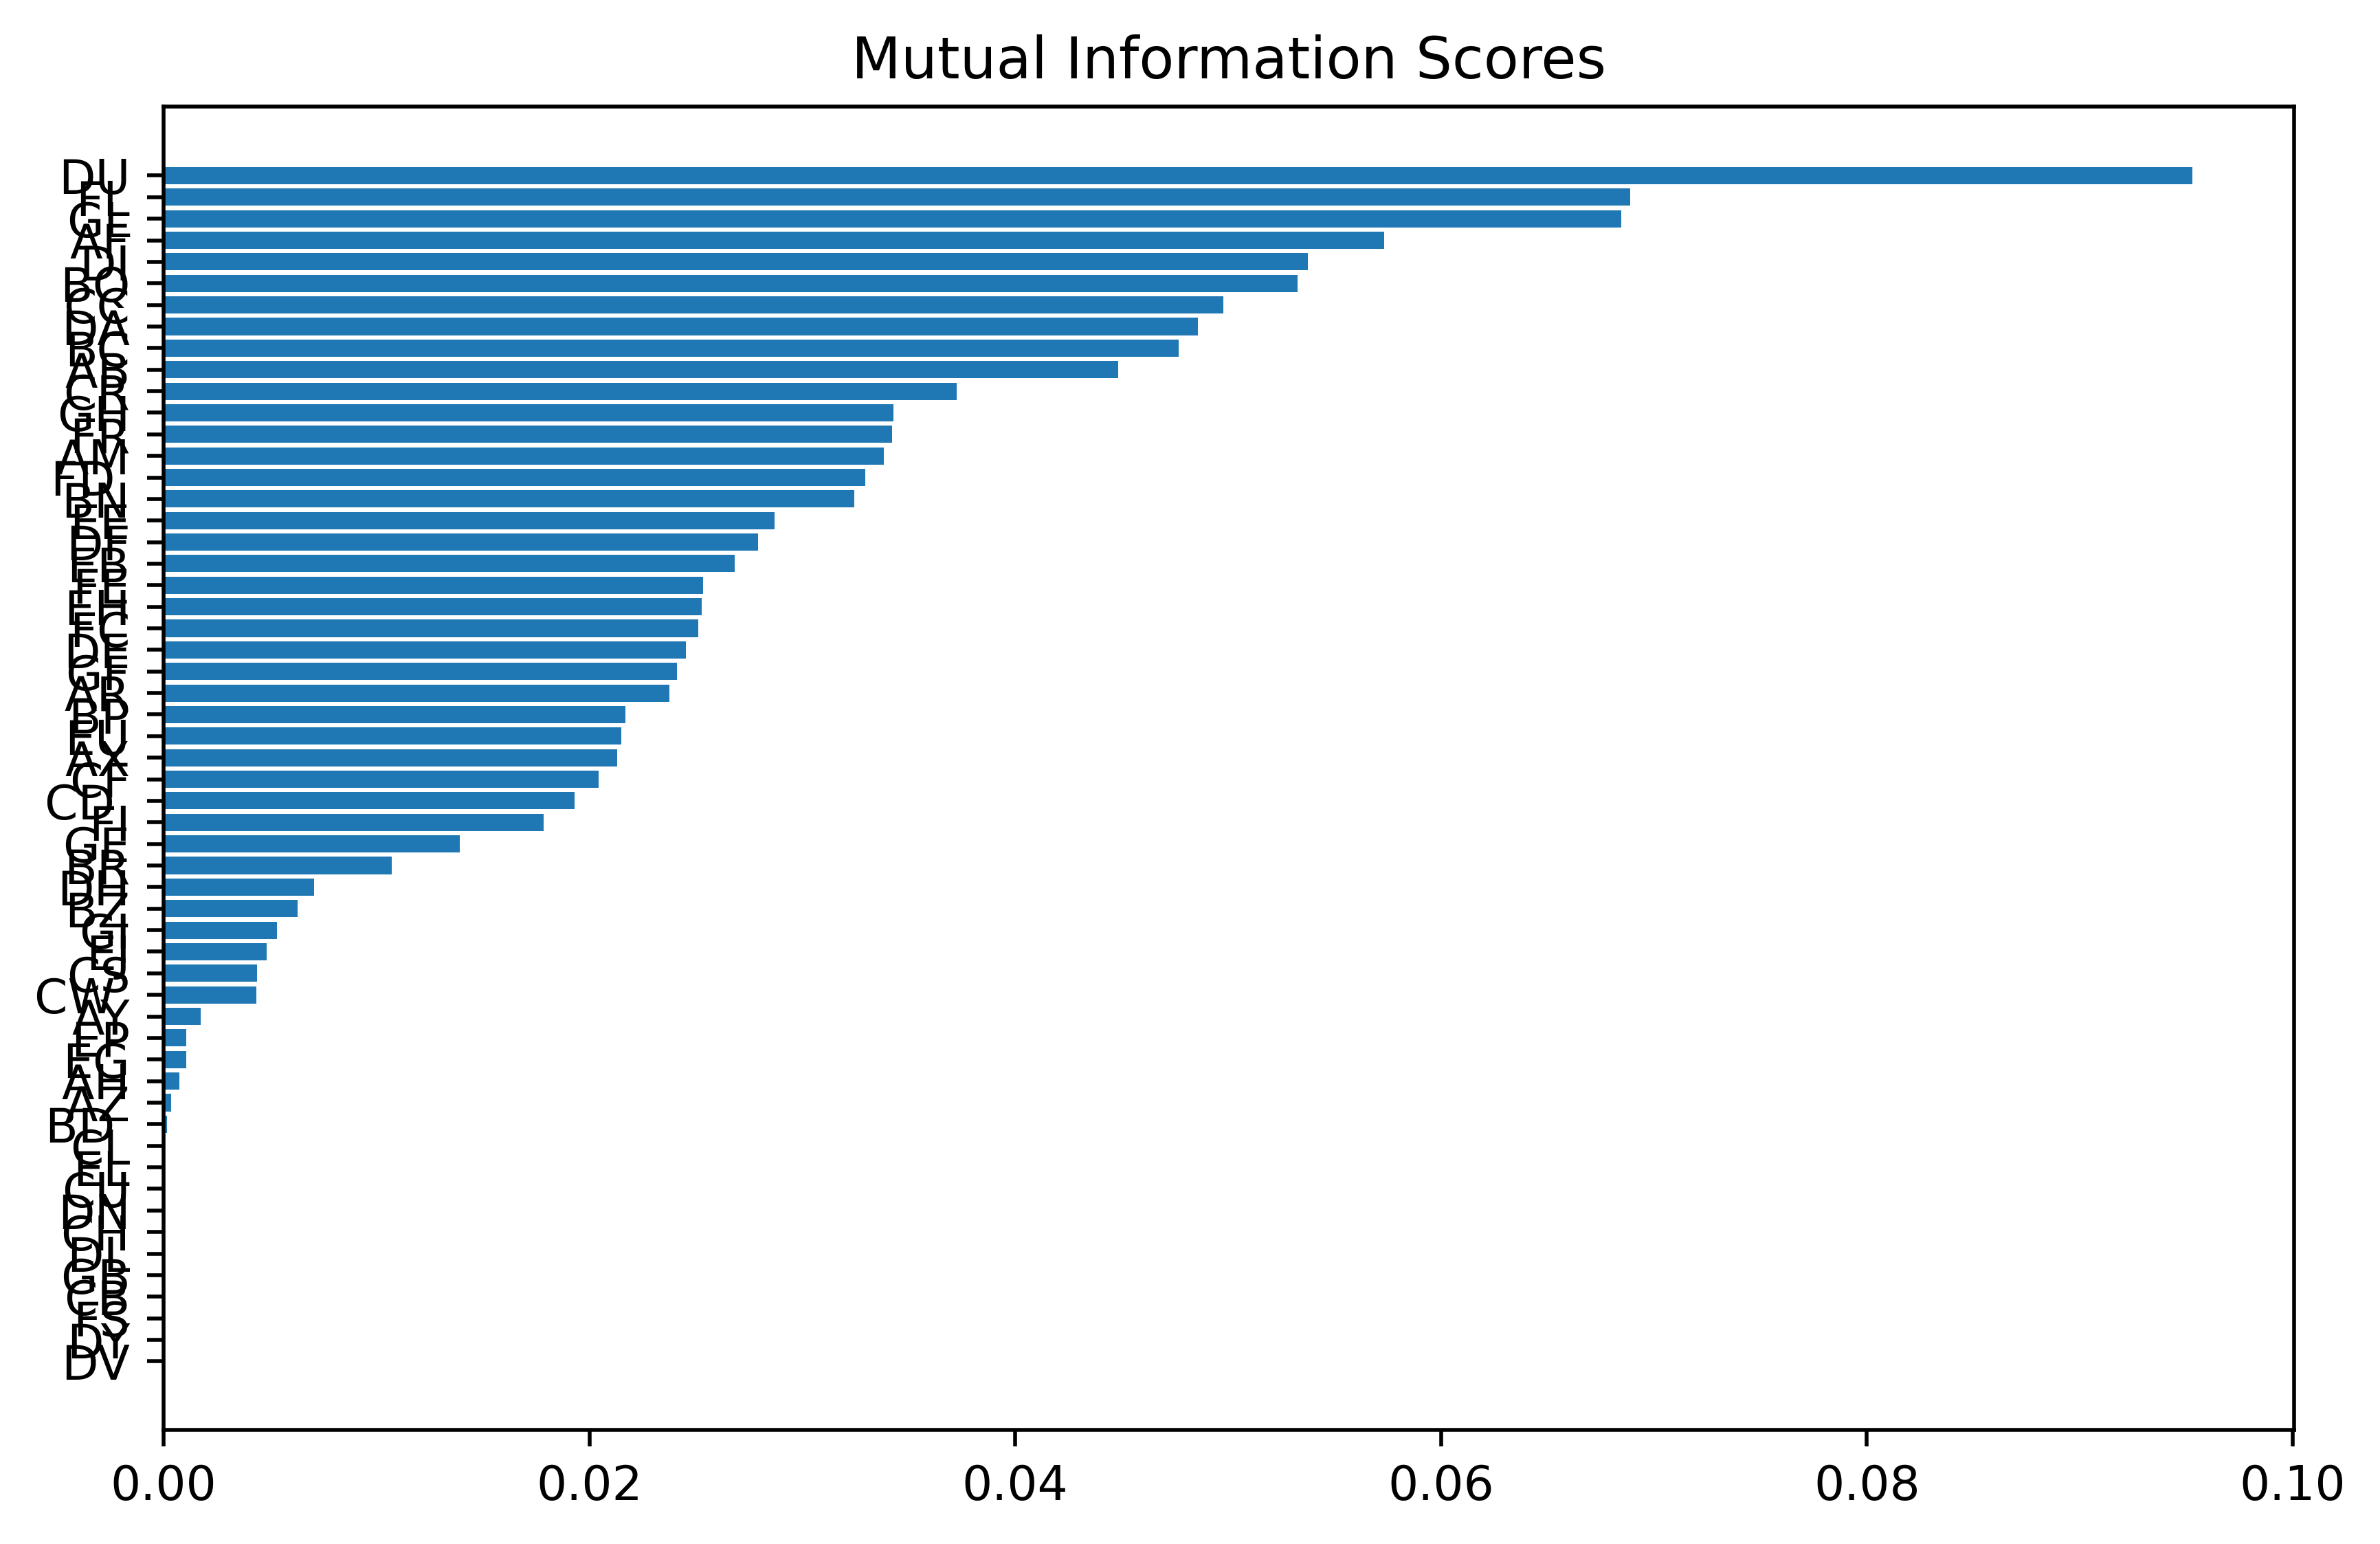

In [13]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=500, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [14]:
columns_to_drop = ['EP','CU','CH','DV','CB','AH','GB','AZ','AY','DY','FS','DL']
train_dropped = train.drop(columns=columns_to_drop)
test_dropped = test.drop(columns=columns_to_drop)




In [15]:
print(train_dropped.shape)
print(test_dropped.shape)

(617, 46)
(5, 45)


### Metric

In [16]:
def competition_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0)) / N_0
    log_loss_1 = -np.sum(y_true * np.log(p_1)) / N_1
    return (log_loss_0 + log_loss_1)/2



In [17]:
def balanced_log_loss(y_true, y_pred):
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    return balanced_log_loss/(N_0+N_1)

In [18]:
def lgb_metric(y_true, y_pred):
    return 'balanced_log_loss', balanced_log_loss(y_true, y_pred), False

### Feature Engineering

**Removing features with low variance**  
VarianceThreshold is a simple baseline approach to feature selection. It removes all features whose variance doesn’t meet some threshold. By default, it removes all zero-variance features, i.e. features that have the same value in all samples.

In [19]:
scaler = StandardScaler()
df, test_df = train_dropped.copy(), test_dropped.copy()
#new_num_cols = train.select_dtypes(include=['float64']).columns
#df[new_num_cols] = scaler.fit_transform(train[new_num_cols])
#test_df[new_num_cols] = scaler.transform(test[new_num_cols])

In [20]:
df.head()

,Id,AB,AF,AM,AR,AX,BC,BD,BN,BP,...,FE,FI,FL,FR,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,22.394407,8.138688,0.699861,5.555634,4126.58731,22.5984,175.638726,...,9028.291921,3.583450,7.298162,1.73855,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,36.968889,8.138688,3.632190,1.229900,5496.92824,19.4205,155.868030,...,6785.003474,10.358927,0.173229,0.49706,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,32.360553,8.138688,6.732840,1.229900,5135.78024,26.4825,128.988531,...,8338.906181,11.626917,7.709560,0.97556,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,77.112203,8.138688,3.685344,1.229900,4169.67738,23.6577,237.282264,...,10965.766040,14.852022,6.122162,0.49706,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,14.103738,8.138688,3.942255,102.151980,5728.73412,24.0108,324.546318,...,16198.049590,13.666727,8.153058,48.50134,146.109943,8524.370502,45.381316,36.262628,0.096614,1


### CV

In [21]:
kf = StratifiedKFold(n_splits=5, random_state=42, shuffle=True)
df['fold'] = -1

for fold, (train_idx, test_idx) in enumerate(kf.split(df, greeks['Alpha'])):
    df.loc[test_idx, 'fold'] = fold

df.groupby('fold')["Class"].value_counts()

fold  Class
0     0        101
      1         23
1     0        102
      1         22
2     0        102
      1         21
3     0        102
      1         21
4     0        102
      1         21
Name: Class, dtype: int64

### Training

In [22]:
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    lgb = LGBMClassifier(boosting_type='goss', learning_rate=0.06733232950390658, n_estimators = 50000, 
                         early_stopping_round = 300, random_state=42,
                        subsample=0.6970532011679706,
                        colsample_bytree=0.6055755840633003,
                         class_weight='balanced',
                         metric='none', is_unbalance=True, max_depth=8)    
    
    lgb.fit(X_train, y_train, eval_set=(X_valid, y_valid), verbose=1000,
            eval_metric=lgb_metric)

    y_pred = lgb.predict_proba(X_valid)
    preds_test  = lgb.predict_proba(test_df.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print(np.mean(balanced_log_losses), np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.308, balanced los loss: 0.179
Fold: 1, log loss: 0.214, balanced los loss: 0.148
Fold: 2, log loss: 0.106, balanced los loss: 0.063
Fold: 3, log loss: 0.25, balanced los loss: 0.137
Fold: 4, log loss: 0.294, balanced los loss: 0.155

Log Loss
[0.30831287935403723, 0.21413704061886185, 0.10622427042190041, 0.2501944865349645, 0.29365369131399]
0.2345044736487508 0.07219851809515844

Balanced Log Loss
[0.17925979599831443, 0.14760157216349679, 0.06277669657302064, 0.13703461189614544, 0.15512332512091284]
0.13635920035037802 0.039328832813185076

Weights
[5.5784956935318775, 6.77499558671577, 15.92947788893, 7.2974264396638056, 6.446483784566488]


In [23]:
test_preds = np.zeros((test_df.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[0.70535778, 0.29464222],
       [0.70535778, 0.29464222],
       [0.70535778, 0.29464222],
       [0.70535778, 0.29464222],
       [0.70535778, 0.29464222]])

In [24]:
import xgboost as xgb

final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
    
    model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    model.fit(X_train, y_train)     

    
    y_pred = model.predict_proba(X_valid)
    preds_test  = model.predict_proba(test_df.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print(np.mean(balanced_log_losses), np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 0.314, balanced los loss: 0.373
Fold: 1, log loss: 0.192, balanced los loss: 0.237
Fold: 2, log loss: 0.15, balanced los loss: 0.159
Fold: 3, log loss: 0.179, balanced los loss: 0.203
Fold: 4, log loss: 0.219, balanced los loss: 0.274

Log Loss
[0.31439575795245067, 0.19185601572775537, 0.1498251110963344, 0.17914890571462677, 0.21921844760714154]
0.2108888476196617 0.0563586998479247

Balanced Log Loss
[0.3726071065604253, 0.23671154846712691, 0.15899557107009465, 0.20260351687916028, 0.2743958446028084]
0.2490627175159231 0.07256456843660386

Weights
[2.6837920758707567, 4.2245509628731694, 6.289483369062783, 4.935748477635926, 3.6443700575987696]


In [25]:
test_preds = np.zeros((test_df.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[0.77179588, 0.22820415],
       [0.77179588, 0.22820415],
       [0.77179588, 0.22820415],
       [0.77179588, 0.22820415],
       [0.77179588, 0.22820415]])

In [26]:
from sklearn.linear_model import SGDClassifier
final_valid_predictions = {}
final_test_predictions = []
scores = []
log_losses = []
balanced_log_losses = []
weights = []

for fold in range(5):
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    valid_ids = valid_df.Id.values.tolist()

    X_train, y_train = train_df.drop(['Id', 'Class', 'fold'], axis=1), train_df['Class']
    X_valid, y_valid = valid_df.drop(['Id', 'Class', 'fold'], axis=1), valid_df['Class']
         
    clf = SGDClassifier(loss='log', penalty='l2',
                           alpha=1e-3, random_state=42,
                           max_iter=5, tol=None)
    clf = clf.fit(X_train, y_train)
    
    y_pred = clf.predict_proba(X_valid)
    preds_test  = clf.predict_proba(test_df.drop(['Id'], axis=1).values)
    
    final_test_predictions.append(preds_test)
    final_valid_predictions.update(dict(zip(valid_ids, y_pred)))

    logloss = log_loss(y_valid, y_pred)
    balanced_logloss = balanced_log_loss(y_valid, y_pred[:, 1])
    log_losses.append(logloss)
    balanced_log_losses.append(balanced_logloss)
    weights.append(1/balanced_logloss)
    
    print(f"Fold: {fold}, log loss: {round(logloss, 3)}, balanced los loss: {round(balanced_logloss, 3)}")

print()
print("Log Loss")
print(log_losses)
print(np.mean(log_losses), np.std(log_losses))
print()
print("Balanced Log Loss")
print(balanced_log_losses)
print(np.mean(balanced_log_losses), np.std(balanced_log_losses))
print()
print("Weights")
print(weights)

Fold: 0, log loss: 5.232, balanced los loss: 8.167
Fold: 1, log loss: 6.395, balanced los loss: 10.081
Fold: 2, log loss: 6.74, balanced los loss: 5.534
Fold: 3, log loss: 5.861, balanced los loss: 7.465
Fold: 4, log loss: 6.154, balanced los loss: 9.41

Log Loss
[5.232143233904103, 6.394841730327237, 6.739870145932476, 5.860756648636936, 6.153794481068783]
6.076281247973907 0.5112453711150742

Balanced Log Loss
[8.167468195362593, 10.081297376454158, 5.5339060178830355, 7.4652631850630105, 9.410329161406166]
8.131652787233794 1.5893252289670554

Weights
[0.12243696284826551, 0.09919358220060014, 0.18070418918725048, 0.1339537502175229, 0.10626620842352895]


In [27]:
test_preds = np.zeros((test_df.shape[0],2))
for i in range(5):
    test_preds[:, 0] += weights[i] * final_test_predictions[i][:, 0]
    test_preds[:, 1] += weights[i] * final_test_predictions[i][:, 1]
test_preds /= sum(weights)
test_preds

array([[1.0000000e+00, 6.8280839e-28],
       [1.0000000e+00, 6.8280839e-28],
       [1.0000000e+00, 6.8280839e-28],
       [1.0000000e+00, 6.8280839e-28],
       [1.0000000e+00, 6.8280839e-28]])

In [28]:
final_valid_predictions = pd.DataFrame.from_dict(final_valid_predictions, orient="index").reset_index()
final_valid_predictions.columns = ['Id', 'class_0', 'class_1']
final_valid_predictions.to_csv(r"oof.csv", index=False)

test_dict = {}
test_dict.update(dict(zip(test.Id.values.tolist(), test_preds)))
submission = pd.DataFrame.from_dict(test_dict, orient="index").reset_index()
submission.columns = ['Id', 'class_0', 'class_1']                       

submission.to_csv(r"submission.csv", index=False)
submission

,Id,class_0,class_1
0,00eed32682bb,1.0,6.828084e-28
1,010ebe33f668,1.0,6.828084e-28
2,02fa521e1838,1.0,6.828084e-28
3,040e15f562a2,1.0,6.828084e-28
4,046e85c7cc7f,1.0,6.828084e-28
